# Building Chains

In [1]:
from langchain_core.messages import HumanMessage, AIMessage
from pprint import pprint

In [29]:
messages = [AIMessage(content="Hello, how are you?", name="LLM")]

messages.extend([HumanMessage(content="I am fine thank you and you?", name="Human")])
messages.extend([AIMessage(content="I am doing fantastic.?", name="LLM")])
# messages.extend([HumanMessage(content="What country has the larges population?.", name="Human")])

In [30]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: LLM

Hello, how are you?
================================ Human Message =================================
Name: Human

I am fine thank you and you?
================================== Ai Message ==================================
Name: LLM

I am doing fantastic.?


## Chat Models

In [50]:
import os
from dotenv import load_dotenv

from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI

load_dotenv()

True

In [53]:
# model = ChatAnthropic(model=)

openai_api_key = os.getenv("OPENAI_API_KEY")
anthropic_api_key = os.getenv("ANTHROPIC_API_KEY")

model = ChatOpenAI(model_name="gpt-4o", openai_api_key = openai_api_key)
# model = ChatAnthropic(model="claude-3-5-sonnet-20241022", api_key=anthropic_api_key)

In [54]:
results = model.invoke(messages)

In [55]:
print(results)
print("====================================")
print(results.response_metadata)

content="I'm just a program, but I'm here and ready to help!" additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 42, 'total_tokens': 56, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'stop', 'logprobs': None} id='run-459cdef4-540a-4b5d-b95e-fe0585ef5164-0' usage_metadata={'input_tokens': 42, 'output_tokens': 14, 'total_tokens': 56, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
{'token_usage': {'completion_tokens': 14, 'prompt_tokens': 42, 'total_tokens': 56, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details'

## Tools

In [56]:
def addition(a:int, b:int) -> int:
    """This tool is used to add two numbers"""
    return a + b

In [57]:
llm_with_tool = model.bind_tools([addition])

In [58]:
llm_with_tool_response = llm_with_tool.invoke([HumanMessage(content="What is the sum of 10 and 15", name="Silas")])

In [59]:
print(llm_with_tool_response)

content='' additional_kwargs={'tool_calls': [{'id': 'call_KunvmjXddLREKDwlLMjEoY5P', 'function': {'arguments': '{"a":10,"b":15}', 'name': 'addition'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 62, 'total_tokens': 81, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-abd37a8a-7b9d-4c6e-a7a6-7d733a980db8-0' tool_calls=[{'name': 'addition', 'args': {'a': 10, 'b': 15}, 'id': 'call_KunvmjXddLREKDwlLMjEoY5P', 'type': 'tool_call'}] usage_metadata={'input_tokens': 62, 'output_tokens': 19, 'total_tokens': 81, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


## Using Messages as State

In [74]:
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import TypedDict, List, Annotated

In [75]:
# This will prevent overriding of messages in every node but rather add the messages to the alredy exisiting list  to retain memory
# This is called a Reducer
class MessageState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]

In [76]:
messages = [
    HumanMessage(content="Hello, how are you doing?", name="Silas"),
    AIMessage(content="Hello Silas, I am fine thank you.", name="LLM")
]

In [77]:
additional_msg = [HumanMessage(content="I am fine as well. How is work on your today?", name="Silas")]

In [78]:
for m in messages:
    m.pretty_print()

================================ Human Message =================================
Name: Silas

Hello, how are you doing?
================================== Ai Message ==================================
Name: LLM

Hello Silas, I am fine thank you.


In [79]:
updated_messages = add_messages(messages, additional_msg)

In [80]:
for m in updated_messages:
    m.pretty_print()

================================ Human Message =================================
Name: Silas

Hello, how are you doing?
================================== Ai Message ==================================
Name: LLM

Hello Silas, I am fine thank you.
================================ Human Message =================================
Name: Silas

I am fine as well. How is work on your today?


## Combine All

In [87]:
# def tool_calling_llm(tools: List, state:MessageState) -> MessageState:
#     openai_api_key = os.getenv("OPENAI_API_KEY")
#     model = ChatOpenAI(model_name="gpt-4o", openai_api_key = openai_api_key)

#     llm_with_tool = model.bind_tools(tools)

#     llm_with_tool_response = llm_with_tool.invoke(state["message"])

#     return {"message": [llm_with_tool_response]}

def tool_calling_llm(state: MessageState, tools=None) -> MessageState:
    tools = tools or []
    openai_api_key = os.getenv("OPENAI_API_KEY")
    model = ChatOpenAI(model_name="gpt-4o", openai_api_key=openai_api_key)

    llm_with_tool = model.bind_tools(tools)
    llm_with_tool_response = llm_with_tool.invoke(state["messages"])

    return {"messages": [llm_with_tool_response]}

## Building Agent Graph

In [88]:
from langgraph.graph import MessagesState, START, END, StateGraph

In [89]:
from functools import partial

# Wrap tool_calling_llm with partial to predefine tools
tool_calling_llm_node = partial(tool_calling_llm, tools=[addition])

builder = StateGraph(MessagesState)

# Pass the callable function without executing it
builder.add_node("tool_calling_llm", tool_calling_llm_node)

builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

graph = builder.compile()


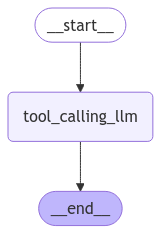

In [90]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Invoke Graph

In [98]:
result = graph.invoke({"messages": [HumanMessage(content="What is the sum of 10 and 15", name="Silas")]})

print(result)

{'messages': [HumanMessage(content='What is the sum of 10 and 15', additional_kwargs={}, response_metadata={}, name='Silas', id='917b52ad-4721-4359-9d95-55faf0983e75'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_w45XHEyaqsz5hAfuRxBnzAwE', 'function': {'arguments': '{"a":10,"b":15}', 'name': 'addition'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 62, 'total_tokens': 81, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_4691090a87', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-004fd8f4-7ad8-496b-957a-0c0cdbd506b0-0', tool_calls=[{'name': 'addition', 'args': {'a': 10, 'b': 15}, 'id': 'call_w45XHEyaqsz5hAfuRxBnzAwE', 'type': 'tool_call'}], usage_metadata={'input_tok

In [99]:
result = graph.invoke({"messages": [HumanMessage(content="Who is the President of France", name="Silas")]})

print(result)

{'messages': [HumanMessage(content='Who is the President of France', additional_kwargs={}, response_metadata={}, name='Silas', id='556e133e-621d-49ad-8713-f91812218c9b'), AIMessage(content='As of October 2023, the President of France is Emmanuel Macron.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 58, 'total_tokens': 75, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'stop', 'logprobs': None}, id='run-049e782f-0660-4b57-a277-031f46d125e3-0', usage_metadata={'input_tokens': 58, 'output_tokens': 17, 'total_tokens': 75, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}
